In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import pickle

In [73]:
ROOT_PATH = "../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs).astype(np.float32)
    
    outputs = None

    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs).astype(np.float32)

    # TO-DO
    # one hot city information and/or position by bins
    # parmater: Number of bins

    return inputs, outputs

def get_all_city_trajectories():
    X = None
    Y = None
    for city in cities:
        x, y = get_city_trajectories(city)
        if X is None:
            X = x
            Y = y
        else:
            X = np.concatenate([X, x], axis=0)
            Y = np.concatenate([Y, y], axis=0)
    return X, Y

In [76]:
def fitData(x, y, transform="MinMax"):
    if transform == 'MinMax':
        scaler = MinMaxScaler()
    elif transform == "Standard":
        scaler = StandardScaler()
    else:
        return x, y

    scaler.fit(x.reshape(-1, 2))
    scaler.fit(y.reshape(-1, 2))
    x_ = scaler.transform(x.reshape(-1, 2)).reshape(-1, 50, 2)
    y_ = scaler.transform(y.reshape(-1, 2)).reshape(-1, 60, 2)

    return x_, y_, scaler

In [77]:
def rmseLoss(pred, y):
    return np.linalg.norm(pred - y) / np.sqrt(len(pred))

In [78]:
def kFoldCV(x, y, scaler, k=5):
    best_loss = float('inf')
    best_model = None

    # Perform kFold validaiton split
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(x):
        # Split dataset into k folds
        X_train, X_test = x[train_index].reshape(-1, 100), x[test_index].reshape(-1, 100)
        y_train, y_test = y[train_index].reshape(-1, 120), y[test_index].reshape(-1, 2)

        # Fit training set
        reg = LinearRegression().fit(X_train, y_train)

        # Predict with validation
        pred = reg.predict(X_test).reshape(-1, 2)
        if scaler:
            pred = scaler.inverse_transform(pred)
            y_test_ = scaler.inverse_transform(y_test)

        # Get validation loss and find best model
        loss = rmseLoss(pred, y_test_)
        if loss < best_loss:
            best_loss = loss
            best_model = reg
        
        # Inverse transform prediction

    return best_model, best_loss

In [61]:
def lr_submission(k=5, csv_name='submission.csv'):
    cols = ["ID"] + [f'v{num}' for num in range(120)]
    df = pd.DataFrame(columns=cols)

    for city in cities:
        # fit and predict with linear regression
        x, y = get_city_trajectories(city)
        x_, y_, scaler = fitData(x, y, 'MinMax')

        # KFold: Get model with best validation
        model, score = kFoldCV(x_, y_, scaler, k)
        print('Best model loss:', score)

        # Predict
        x_test, _ = get_city_trajectories(city, split='test')
        test_pred = model.predict(x_test.reshape(-1, 50*2))

        idx = np.array([f'{num}_{city}' for num in range(len(x_test))])
        pred_df = pd.DataFrame(np.hstack([idx[:, None], test_pred]), columns=cols)
        df = pd.concat([df, pred_df], axis=0)

        # Plot random sampling and prediction
    df.to_csv(csv_name, index=False)
    return model

In [69]:
def lr_submission_big_model(k=5, csv_name='submission_big.csv'):
    cols = ["ID"] + [f'v{num}' for num in range(120)]
    df = pd.DataFrame(columns=cols)

    X, Y = get_all_city_trajectories()
    x_, y_, scaler = fitData(X, Y, 'MinMax')
    
    # KFold: Get model with best validation
    model, score = kFoldCV(x_, y_, scaler, k)
    print('Best model loss:', score)

    for city in cities:
        x_test, _ = get_city_trajectories(city, split='test')
        test_pred = model.predict(x_test.reshape(-1, 50*2))

        idx = np.array([f'{num}_{city}' for num in range(len(x_test))])
        pred_df = pd.DataFrame(np.hstack([idx[:, None], test_pred]), columns=cols)
        df = pd.concat([df, pred_df], axis=0)
    
    df.to_csv(csv_name, index=False)
    return model

In [70]:
big_model = lr_submission_big_model()
model = lr_submission(k=10)

Best model loss: 6.5201752827739465


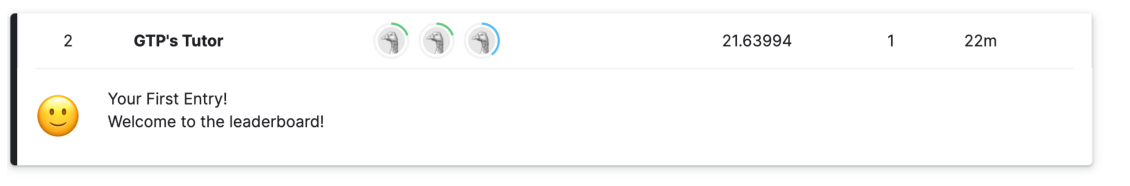

In [7]:
fig, ax = plt.subplots(figsize=(20,20))
img = mpimg.imread('linear_reg_k_5.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

### Linear Regression with K=5 fold validation and MinMax scaling had an RMSE score of 21.63994, compared to the k-fold validation loss of around 6.5. This is a sign of overfitting.

### It took a total of 1m 13.4 sec to train.

# Plot random sample

In [81]:
df = pd.read_csv('submission.csv')
df_big = pd.read_csv('submission_big.csv')

In [19]:
def plot_path(input, output):
    # Takes in input and output, dim=2
    xMin = min(min(input[:, 0]), min(output[:, 0]))
    xMax = max(max(input[:,0]), max(output[:, 0]))
    yMin = min(min(input[:,1]), min(output[:, 1]))
    yMax = max(max(input[:,1]), max(output[:, 1]))

    ax1 = plt.subplot(1, 3, 1)
    ax1.set_xlim(left=xMin, right=xMax)
    ax1.set_ylim(bottom=yMin, top=yMax)
    ax2 = plt.subplot(1, 3, 2, sharey=ax1, sharex=ax1)
    ax3 = plt.subplot(1, 3, 3, sharey=ax1, sharex=ax1)

    ax1.scatter(input[:, 0], input[:, 1])
    ax2.scatter(output[:, 0], output[:, 1], c='orange')
    ax3.scatter(input[:, 0], input[:, 1])
    ax3.scatter(output[:, 0], output[:, 1])
    plt.show()

def random_sample(df, n=10):
    return df.sample(n=10)

True


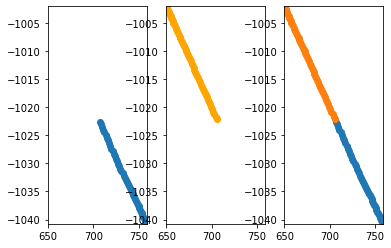

Prediction


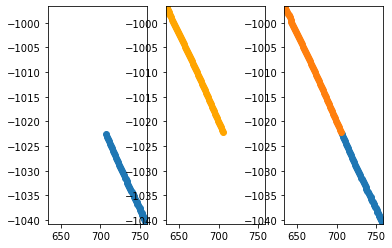

True


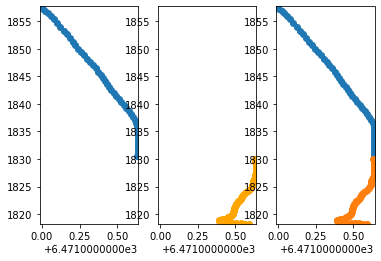

Prediction


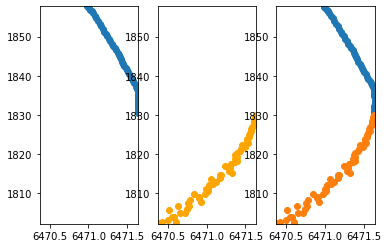

True


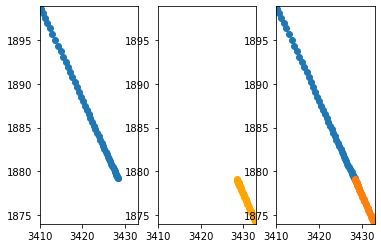

Prediction


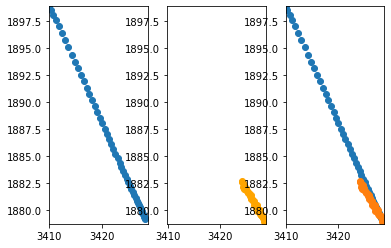

True


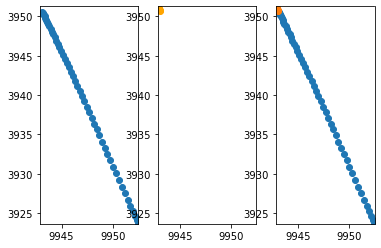

Prediction


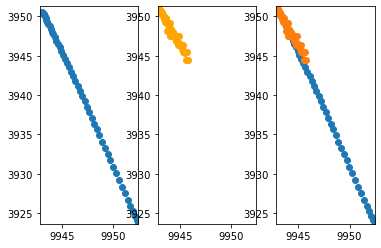

True


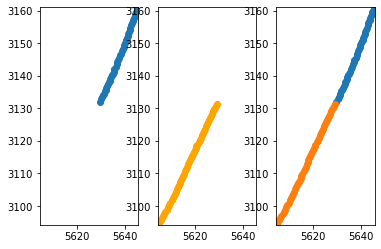

Prediction


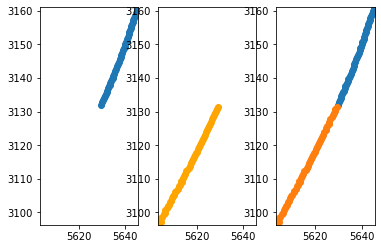

True


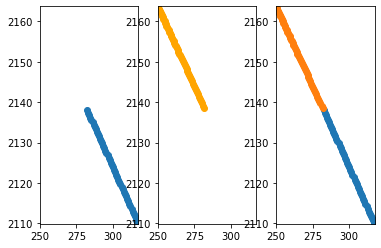

Prediction


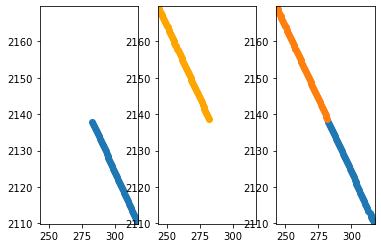

In [79]:
# Train
def plot_train_examples(model, n=1):
    for city in cities:
        x, y = get_city_trajectories(city)
        pred = model.predict(x.reshape(-1, 50*2)).reshape(-1, 60, 2)
        randidx = np.random.randint(len(x))
        print('True')
        plot_path(x[randidx], y[randidx])
        print('Prediction')
        plot_path(x[randidx], pred[randidx])

# plot_train_examples(model)
plot_train_examples(big_model)

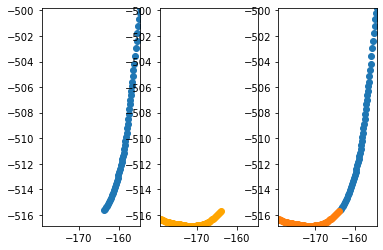

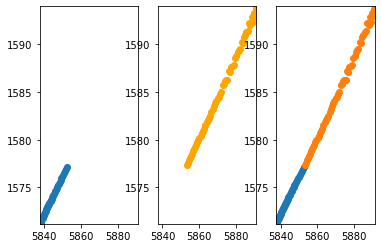

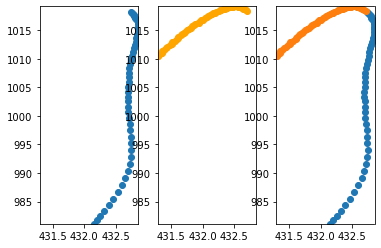

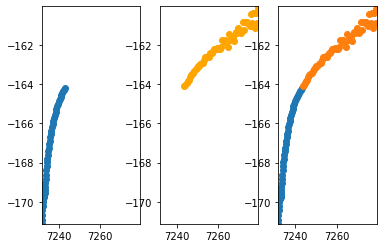

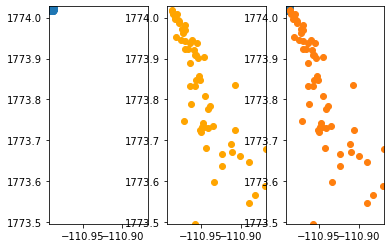

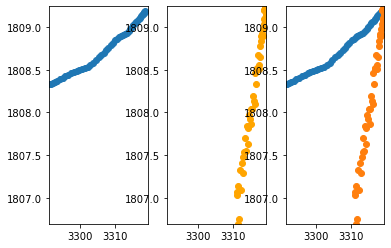

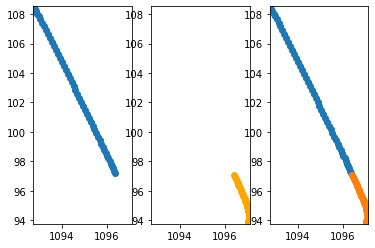

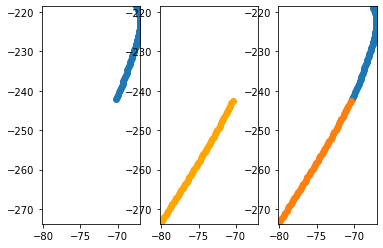

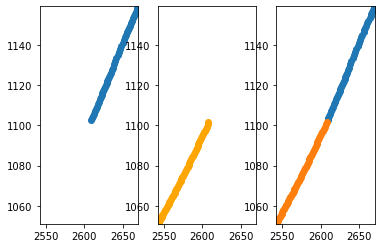

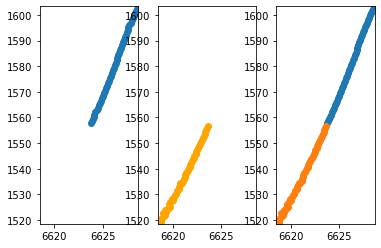

In [86]:
def plot_test_examples(df, n):
    for index, row in random_sample(df, n).iterrows():
        id = row['ID'].split('_')
        city = id[1]
        idx = int(id[0])
        x_test, _ = get_city_trajectories(city, split='test')

        pred = np.array(row[1:]).reshape(60, 2)
        plot_path(x_test[idx, :, :], pred)

# plot_test_examples(df, 5)
plot_test_examples(df_big, 5)